In [1]:
import pandas as pd
from copy import deepcopy
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import gpplot
from scipy.stats import yeojohnson, rankdata
from sklearn.base import clone
import numpy as np
from sklearn import preprocessing
import warnings
import matplotlib
from tqdm import tqdm
from scipy.stats import mannwhitneyu

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
def perform_mannwhitney_tests(chrtest, gene_col, phenotype):
    results = []
    # Get unique values from the specified columns
    experiment_seq = chrtest['chipseq'].unique()
    DataSet = chrtest['DataSet'].unique()
    Domain = chrtest['Domain'].unique()

    # Iterate over the combinations of parameters
    for experiment in tqdm(experiment_seq):
        
        for data in tqdm(DataSet):
            if data == 'InHouse':
                alter = 'greater'
            elif data == 'Nunez':
                alter = 'greater'
            elif data == 'Gilbert':
                alter = 'less' 
            for krab in tqdm(Domain):
                    chrtest_subset = chrtest[(chrtest['chipseq'] == experiment) & 
                                             (chrtest['Domain'] == krab) & 
                                             (chrtest['DataSet'] == data) ]
                    for gene in chrtest_subset[gene_col].unique():
                        gene_sp = chrtest_subset[chrtest_subset[gene_col] == gene]
                        binary_col = 'overlap with peak'
                        if (sum(gene_sp[binary_col] == 1) >= 10) & (sum(gene_sp[binary_col] == 0) >= 10):
                            _, pval = mannwhitneyu(gene_sp[gene_sp[binary_col] == 0][phenotype], 
                                                   gene_sp[gene_sp[binary_col] == 1][phenotype], 
                                                   alternative=alter, method="asymptotic")
                            results.append({
                                'chipseq': experiment,
                                'DataSet': data,
                                'Domain': krab,
                                'gene': gene,
                                'pval': pval
                            })
                        else:
                            print(f"{gene}: Sample size in overlap or non-overlap < 10")
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    return results_df


In [3]:
dataOut = '../Data/CleanedScaledData/'
GilbertRicinScaledData = pd.read_csv(dataOut+'GilbertRicinScaledData.csv')
inHouseZim3ScaledData = pd.read_csv(dataOut+'inHouseZim3ScaledData.csv')
inHouseKox1ScaledData = pd.read_csv(dataOut+'inHouseKox1ScaledData.csv')
nunezScaledData = pd.read_csv(dataOut+'nunezScaledData.csv')


In [4]:
combinedData = pd.concat([nunezScaledData, inHouseKox1ScaledData, inHouseZim3ScaledData, GilbertRicinScaledData])

In [5]:
# ess gene
ess_noness = pd.read_csv('../Data/PrimaryLibrary/design/essentials_nonessentials_CRISPRi_tiling_designs_v2.csv')
EssGene = ess_noness[ess_noness.Category == 'Essential']['Target Gene Symbol'].unique()
# chip
chip_path = '../Data/CHiP_Histone/'
chrtest = pd.read_csv(chip_path+'CHIPseqPeakOverlap.csv')

# only guide with phenotype
InhouseEssCHIP = chrtest[(chrtest.DataSet == 'InHouse') & (chrtest['Target Gene Symbol'].isin(EssGene))]
otherCHIP = chrtest[~(chrtest.DataSet == 'InHouse')]
newCHIP = pd.concat([InhouseEssCHIP,otherCHIP])

newCHIP[['condition', 'Domain', 'DataSet','chipseq']].value_counts()

condition  Domain  DataSet  chipseq        
K562       Kox1    Nunez    H3k27me3_K562      68575
                            H3k27me3_HCT116    68575
                            H3k27ac_K562       68575
                            H3k27ac_HCT116     68575
                            H3k27ac_A549       68575
                            H3K4me3_K562       68575
                            H3K4me3_HCT116     68575
                            H3K4me3_A549       68575
HCT116     Kox1    InHouse  H3K4me3_A549       42609
                            H3k27me3_HCT116    42609
                            H3k27ac_K562       42609
                            H3k27ac_HCT116     42609
                            H3k27ac_A549       42609
                            H3K4me3_K562       42609
                            H3K4me3_HCT116     42609
A549       Zim3    InHouse  H3k27ac_HCT116     42609
                            H3k27me3_K562      42609
                            H3k27me3_HCT116    42609
  

In [6]:
shortenNewCHIP = newCHIP[['Target Gene Symbol', 'chromosome', 'sgRNA Context Sequence',
     'Domain', 'DataSet',
      'overlap with peak', 'chipseq']].drop_duplicates().copy()

In [7]:
shortenNewCHIP[['Domain', 'DataSet', 'chipseq']].value_counts()
# more datapoint in Zim3 InHouse because we are taking the union of two cell lines

Domain  DataSet  chipseq        
Kox1    Nunez    H3K4me3_A549       68575
                 H3K4me3_HCT116     68575
                 H3k27me3_K562      68575
                 H3k27me3_HCT116    68575
                 H3k27ac_K562       68575
                 H3k27ac_HCT116     68575
                 H3k27ac_A549       68575
                 H3K4me3_K562       68575
Zim3    InHouse  H3k27me3_HCT116    42762
                 H3k27ac_K562       42762
                 H3k27ac_HCT116     42762
                 H3k27ac_A549       42762
                 H3K4me3_K562       42762
                 H3K4me3_HCT116     42762
                 H3K4me3_A549       42762
                 H3k27me3_K562      42762
Kox1    InHouse  H3k27me3_K562      42761
                 H3k27me3_HCT116    42761
                 H3k27ac_K562       42761
                 H3k27ac_HCT116     42761
                 H3k27ac_A549       42761
                 H3K4me3_K562       42761
                 H3K4me3_HCT116     42761
 

In [8]:
combinedData[['Domain', 'DataSet']].value_counts()

Domain  DataSet
Kox1    Nunez      68575
        InHouse    42104
Zim3    InHouse    42104
Kox1    Gilbert    18509
dtype: int64

In [9]:
shortenNewCHIP['sgRNA Context Sequence'] = shortenNewCHIP['sgRNA Context Sequence'].str.upper()
combinedData['sgRNA Context Sequence'] = combinedData['sgRNA Context Sequence'].str.upper()

In [10]:
combinedDataCHIP = pd.merge(shortenNewCHIP,combinedData, how = 'inner',
                           on = ['Target Gene Symbol',
                                 'sgRNA Context Sequence',
                                 'Domain', 'DataSet'])


In [11]:
combinedDataCHIP[['Domain', 'DataSet', 'chipseq']].value_counts()

Domain  DataSet  chipseq        
Kox1    Nunez    H3K4me3_A549       68575
                 H3K4me3_HCT116     68575
                 H3k27me3_K562      68575
                 H3k27me3_HCT116    68575
                 H3k27ac_K562       68575
                 H3k27ac_HCT116     68575
                 H3k27ac_A549       68575
                 H3K4me3_K562       68575
Zim3    InHouse  H3k27me3_HCT116    42104
                 H3k27ac_K562       42104
                 H3k27ac_HCT116     42104
                 H3k27ac_A549       42104
                 H3K4me3_K562       42104
                 H3K4me3_HCT116     42104
                 H3K4me3_A549       42104
                 H3k27me3_K562      42104
Kox1    InHouse  H3k27me3_K562      42104
                 H3k27me3_HCT116    42104
                 H3k27ac_K562       42104
                 H3k27ac_HCT116     42104
                 H3k27ac_A549       42104
                 H3K4me3_K562       42104
                 H3K4me3_HCT116     42104
 

In [12]:
chipPath = '../Data/CleanedScaledData/CHIP/'
combinedDataCHIP.to_csv(chipPath+'CHIPwithScaledData.csv', index = False)

In [13]:
results_df = perform_mannwhitney_tests(combinedDataCHIP, 'Target Gene Symbol', 'doubleZscore')


  0%|                                                                                                                                                              | 0/3 [00:00<?, ?it/s]

  0%|                                                                                                                                                              | 0/2 [00:00<?, ?it/s]

COPS3: Sample size in overlap or non-overlap < 10
YEATS4: Sample size in overlap or non-overlap < 10
RPAP1: Sample size in overlap or non-overlap < 10
DHX15: Sample size in overlap or non-overlap < 10
MRPL45: Sample size in overlap or non-overlap < 10
MED7: Sample size in overlap or non-overlap < 10
RBBP6: Sample size in overlap or non-overlap < 10
SNUPN: Sample size in overlap or non-overlap < 10
UMPS: Sample size in overlap or non-overlap < 10
E4F1: Sample size in overlap or non-overlap < 10
SYS1: Sample size in overlap or non-overlap < 10
RPP21: Sample size in overlap or non-overlap < 10
SNRPF: Sample size in overlap or non-overlap < 10
LARS1: Sample size in overlap or non-overlap < 10
SNRNP70: Sample size in overlap or non-overlap < 10
PSMD1: Sample size in overlap or non-overlap < 10
SRSF2: Sample size in overlap or non-overlap < 10
ELP6: Sample size in overlap or non-overlap < 10
MARS1: Sample size in overlap or non-overlap < 10
GMPPB: Sample size in overlap or non-overlap < 10
E



 50%|███████████████████████████████████████████████████████████████████████████                                                                           | 1/2 [00:00<00:00,  1.33it/s]


PIGV: Sample size in overlap or non-overlap < 10
PUM3: Sample size in overlap or non-overlap < 10
ZNF131: Sample size in overlap or non-overlap < 10
HEATR1: Sample size in overlap or non-overlap < 10
MRPS24: Sample size in overlap or non-overlap < 10
ANAPC4: Sample size in overlap or non-overlap < 10
WDR55: Sample size in overlap or non-overlap < 10
NMT1: Sample size in overlap or non-overlap < 10
VPS28: Sample size in overlap or non-overlap < 10
GTF3C2: Sample size in overlap or non-overlap < 10
NBAS: Sample size in overlap or non-overlap < 10
NAPG: Sample size in overlap or non-overlap < 10
RAD9A: Sample size in overlap or non-overlap < 10
MROH6: Sample size in overlap or non-overlap < 10
CKAP5: Sample size in overlap or non-overlap < 10
PRPF3: Sample size in overlap or non-overlap < 10
COX6B1: Sample size in overlap or non-overlap < 10
EIF4G1: Sample size in overlap or non-overlap < 10
RSL1D1: Sample size in overlap or non-overlap < 10
CACTIN: Sample size in overlap or non-overlap 



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.30it/s]

 33%|██████████████████████████████████████████████████                                                                                                    | 1/3 [00:01<00:03,  1.55s/it]

MRPS23: Sample size in overlap or non-overlap < 10
MRPS15: Sample size in overlap or non-overlap < 10
PRMT5: Sample size in overlap or non-overlap < 10
HINFP: Sample size in overlap or non-overlap < 10
WEE1: Sample size in overlap or non-overlap < 10
ITGAV: Sample size in overlap or non-overlap < 10
SRCAP: Sample size in overlap or non-overlap < 10
PMVK: Sample size in overlap or non-overlap < 10
SLC25A28: Sample size in overlap or non-overlap < 10
DDOST: Sample size in overlap or non-overlap < 10
SKA1: Sample size in overlap or non-overlap < 10
ERCC6L: Sample size in overlap or non-overlap < 10
PIGV: Sample size in overlap or non-overlap < 10
PUM3: Sample size in overlap or non-overlap < 10
ZNF131: Sample size in overlap or non-overlap < 10
HEATR1: Sample size in overlap or non-overlap < 10
MRPS24: Sample size in overlap or non-overlap < 10
ANAPC4: Sample size in overlap or non-overlap < 10
WDR55: Sample size in overlap or non-overlap < 10
NMT1: Sample size in overlap or non-overlap <



  0%|                                                                                                                                                              | 0/2 [00:00<?, ?it/s]

ACTR6: Sample size in overlap or non-overlap < 10
AFG3L2: Sample size in overlap or non-overlap < 10
ANAPC13: Sample size in overlap or non-overlap < 10
AP2M1: Sample size in overlap or non-overlap < 10
ATP1A1: Sample size in overlap or non-overlap < 10
ATP6V1B2: Sample size in overlap or non-overlap < 10
ATP6V1C1: Sample size in overlap or non-overlap < 10
ATR: Sample size in overlap or non-overlap < 10
ATXN10: Sample size in overlap or non-overlap < 10
AURKB: Sample size in overlap or non-overlap < 10
BCAS2: Sample size in overlap or non-overlap < 10
BCR: Sample size in overlap or non-overlap < 10
BDP1: Sample size in overlap or non-overlap < 10
BIRC5: Sample size in overlap or non-overlap < 10
BMS1: Sample size in overlap or non-overlap < 10
BNIP1: Sample size in overlap or non-overlap < 10
BUB3: Sample size in overlap or non-overlap < 10
BUD13: Sample size in overlap or non-overlap < 10
C14orf178: Sample size in overlap or non-overlap < 10
C17orf49: Sample size in overlap or non-ov

POLR3B: Sample size in overlap or non-overlap < 10
POP5: Sample size in overlap or non-overlap < 10
PRIM2: Sample size in overlap or non-overlap < 10
PRMT5: Sample size in overlap or non-overlap < 10
PRPF18: Sample size in overlap or non-overlap < 10
PRPF3: Sample size in overlap or non-overlap < 10
PRPF8: Sample size in overlap or non-overlap < 10
PSMA3: Sample size in overlap or non-overlap < 10
PSMA4: Sample size in overlap or non-overlap < 10
PSMB5: Sample size in overlap or non-overlap < 10
PSMB6: Sample size in overlap or non-overlap < 10
PSMB7: Sample size in overlap or non-overlap < 10
PSMC1: Sample size in overlap or non-overlap < 10
PSMC2: Sample size in overlap or non-overlap < 10
PSMC4: Sample size in overlap or non-overlap < 10
PSMD1: Sample size in overlap or non-overlap < 10
PSMD2: Sample size in overlap or non-overlap < 10
PSMD4: Sample size in overlap or non-overlap < 10
PSMD6: Sample size in overlap or non-overlap < 10
PSMD7: Sample size in overlap or non-overlap < 10



 50%|███████████████████████████████████████████████████████████████████████████                                                                           | 1/2 [00:01<00:01,  1.71s/it]


TIMELESS: Sample size in overlap or non-overlap < 10
TOP2A: Sample size in overlap or non-overlap < 10
TPX2: Sample size in overlap or non-overlap < 10
TRMT10C: Sample size in overlap or non-overlap < 10
TRRAP: Sample size in overlap or non-overlap < 10
TSEN2: Sample size in overlap or non-overlap < 10
TTC1: Sample size in overlap or non-overlap < 10
TTK: Sample size in overlap or non-overlap < 10
TUBGCP2: Sample size in overlap or non-overlap < 10
TUBGCP3: Sample size in overlap or non-overlap < 10
U2AF1: Sample size in overlap or non-overlap < 10
UBA3: Sample size in overlap or non-overlap < 10
UMPS: Sample size in overlap or non-overlap < 10
UQCRB: Sample size in overlap or non-overlap < 10
UQCRFS1: Sample size in overlap or non-overlap < 10
UTP3: Sample size in overlap or non-overlap < 10
UTP6: Sample size in overlap or non-overlap < 10
VARS2: Sample size in overlap or non-overlap < 10
VCP: Sample size in overlap or non-overlap < 10
VPS54: Sample size in overlap or non-overlap < 1



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.04it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 2/3 [00:03<00:01,  1.77s/it]

  0%|                                                                                                                                                              | 0/2 [00:00<?, ?it/s]

 50%|███████████████████████████████████████████████████████████████████████████                                                                           | 1/2 [00:00<00:00,  3.44it/s]

ARF1: Sample size in overlap or non-overlap < 10
ARL1: Sample size in overlap or non-overlap < 10
CARM1: Sample size in overlap or non-overlap < 10
COG1: Sample size in overlap or non-overlap < 10
COG3: Sample size in overlap or non-overlap < 10
COPB1: Sample size in overlap or non-overlap < 10
CREBBP: Sample size in overlap or non-overlap < 10
EIF6: Sample size in overlap or non-overlap < 10
GBF1: Sample size in overlap or non-overlap < 10
GOLGA1: Sample size in overlap or non-overlap < 10
HEATR1: Sample size in overlap or non-overlap < 10
IGF2R: Sample size in overlap or non-overlap < 10
ILF2: Sample size in overlap or non-overlap < 10
ILF3: Sample size in overlap or non-overlap < 10
MCL1: Sample size in overlap or non-overlap < 10
PSMC6: Sample size in overlap or non-overlap < 10
QSOX2: Sample size in overlap or non-overlap < 10
RAB1A: Sample size in overlap or non-overlap < 10
RAB1B: Sample size in overlap or non-overlap < 10
RAB2A: Sample size in overlap or non-overlap < 10
SAR1A:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.97it/s]

  0%|                                                                                                                                                              | 0/3 [00:00<?, ?it/s]

  0%|                                                                                                                                                              | 0/2 [00:00<?, ?it/s]

COPS3: Sample size in overlap or non-overlap < 10
YEATS4: Sample size in overlap or non-overlap < 10
RPAP1: Sample size in overlap or non-overlap < 10
DHX15: Sample size in overlap or non-overlap < 10
MRPL45: Sample size in overlap or non-overlap < 10
MED7: Sample size in overlap or non-overlap < 10
RBBP6: Sample size in overlap or non-overlap < 10
SNUPN: Sample size in overlap or non-overlap < 10
UMPS: Sample size in overlap or non-overlap < 10
E4F1: Sample size in overlap or non-overlap < 10
SYS1: Sample size in overlap or non-overlap < 10
RPP21: Sample size in overlap or non-overlap < 10
SNRPF: Sample size in overlap or non-overlap < 10
LARS1: Sample size in overlap or non-overlap < 10
SNRNP70: Sample size in overlap or non-overlap < 10
PSMD1: Sample size in overlap or non-overlap < 10
SRSF2: Sample size in overlap or non-overlap < 10
ELP6: Sample size in overlap or non-overlap < 10
MARS1: Sample size in overlap or non-overlap < 10
GMPPB: Sample size in overlap or non-overlap < 10
E



 50%|███████████████████████████████████████████████████████████████████████████                                                                           | 1/2 [00:00<00:00,  1.43it/s]


NAPG: Sample size in overlap or non-overlap < 10
RAD9A: Sample size in overlap or non-overlap < 10
MROH6: Sample size in overlap or non-overlap < 10
CKAP5: Sample size in overlap or non-overlap < 10
PRPF3: Sample size in overlap or non-overlap < 10
COX6B1: Sample size in overlap or non-overlap < 10
EIF4G1: Sample size in overlap or non-overlap < 10
RSL1D1: Sample size in overlap or non-overlap < 10
CACTIN: Sample size in overlap or non-overlap < 10
GET4: Sample size in overlap or non-overlap < 10
PIGS: Sample size in overlap or non-overlap < 10
TEDC1: Sample size in overlap or non-overlap < 10
COPS3: Sample size in overlap or non-overlap < 10
YEATS4: Sample size in overlap or non-overlap < 10
RPAP1: Sample size in overlap or non-overlap < 10
DHX15: Sample size in overlap or non-overlap < 10
MRPL45: Sample size in overlap or non-overlap < 10
MED7: Sample size in overlap or non-overlap < 10
RBBP6: Sample size in overlap or non-overlap < 10
SNUPN: Sample size in overlap or non-overlap < 



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.43it/s]

 33%|██████████████████████████████████████████████████                                                                                                    | 1/3 [00:01<00:02,  1.40s/it]


RAD9A: Sample size in overlap or non-overlap < 10
MROH6: Sample size in overlap or non-overlap < 10
CKAP5: Sample size in overlap or non-overlap < 10
PRPF3: Sample size in overlap or non-overlap < 10
COX6B1: Sample size in overlap or non-overlap < 10
EIF4G1: Sample size in overlap or non-overlap < 10
RSL1D1: Sample size in overlap or non-overlap < 10
CACTIN: Sample size in overlap or non-overlap < 10
GET4: Sample size in overlap or non-overlap < 10
PIGS: Sample size in overlap or non-overlap < 10
TEDC1: Sample size in overlap or non-overlap < 10




  0%|                                                                                                                                                              | 0/2 [00:00<?, ?it/s]

ACTR6: Sample size in overlap or non-overlap < 10
AFG3L2: Sample size in overlap or non-overlap < 10
ANAPC13: Sample size in overlap or non-overlap < 10
AP2M1: Sample size in overlap or non-overlap < 10
ATP1A1: Sample size in overlap or non-overlap < 10
ATP6V1B2: Sample size in overlap or non-overlap < 10
ATP6V1C1: Sample size in overlap or non-overlap < 10
ATR: Sample size in overlap or non-overlap < 10
ATXN10: Sample size in overlap or non-overlap < 10
AURKB: Sample size in overlap or non-overlap < 10
BCAS2: Sample size in overlap or non-overlap < 10
BCR: Sample size in overlap or non-overlap < 10
BDP1: Sample size in overlap or non-overlap < 10
BIRC5: Sample size in overlap or non-overlap < 10
BMS1: Sample size in overlap or non-overlap < 10
BNIP1: Sample size in overlap or non-overlap < 10
BUB3: Sample size in overlap or non-overlap < 10
BUD13: Sample size in overlap or non-overlap < 10
C14orf178: Sample size in overlap or non-overlap < 10
C17orf49: Sample size in overlap or non-ov

PRMT5: Sample size in overlap or non-overlap < 10
PRPF18: Sample size in overlap or non-overlap < 10
PRPF3: Sample size in overlap or non-overlap < 10
PRPF8: Sample size in overlap or non-overlap < 10
PSMA3: Sample size in overlap or non-overlap < 10
PSMA4: Sample size in overlap or non-overlap < 10
PSMB5: Sample size in overlap or non-overlap < 10
PSMB6: Sample size in overlap or non-overlap < 10
PSMB7: Sample size in overlap or non-overlap < 10
PSMC1: Sample size in overlap or non-overlap < 10
PSMC2: Sample size in overlap or non-overlap < 10
PSMC4: Sample size in overlap or non-overlap < 10
PSMD1: Sample size in overlap or non-overlap < 10
PSMD2: Sample size in overlap or non-overlap < 10
PSMD4: Sample size in overlap or non-overlap < 10
PSMD6: Sample size in overlap or non-overlap < 10
PSMD7: Sample size in overlap or non-overlap < 10
RABGGTB: Sample size in overlap or non-overlap < 10
RACGAP1: Sample size in overlap or non-overlap < 10
RAD51: Sample size in overlap or non-overlap 



 50%|███████████████████████████████████████████████████████████████████████████                                                                           | 1/2 [00:01<00:01,  1.75s/it]

STAT5B: Sample size in overlap or non-overlap < 10
SUPV3L1: Sample size in overlap or non-overlap < 10
SURF6: Sample size in overlap or non-overlap < 10
TAMM41: Sample size in overlap or non-overlap < 10
TARS2: Sample size in overlap or non-overlap < 10
TBCD: Sample size in overlap or non-overlap < 10
TBCE: Sample size in overlap or non-overlap < 10
TCERG1: Sample size in overlap or non-overlap < 10
TEX10: Sample size in overlap or non-overlap < 10
THG1L: Sample size in overlap or non-overlap < 10
TICRR: Sample size in overlap or non-overlap < 10
TIMELESS: Sample size in overlap or non-overlap < 10
TOP2A: Sample size in overlap or non-overlap < 10
TPX2: Sample size in overlap or non-overlap < 10
TRMT10C: Sample size in overlap or non-overlap < 10
TRRAP: Sample size in overlap or non-overlap < 10
TSEN2: Sample size in overlap or non-overlap < 10
TTC1: Sample size in overlap or non-overlap < 10
TTK: Sample size in overlap or non-overlap < 10
TUBGCP2: Sample size in overlap or non-overlap



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.01it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 2/3 [00:03<00:01,  1.74s/it]

  0%|                                                                                                                                                              | 0/2 [00:00<?, ?it/s]

 50%|███████████████████████████████████████████████████████████████████████████                                                                           | 1/2 [00:00<00:00,  3.43it/s]

ARF1: Sample size in overlap or non-overlap < 10
ARL1: Sample size in overlap or non-overlap < 10
CARM1: Sample size in overlap or non-overlap < 10
COG1: Sample size in overlap or non-overlap < 10
COG3: Sample size in overlap or non-overlap < 10
COPB1: Sample size in overlap or non-overlap < 10
CREBBP: Sample size in overlap or non-overlap < 10
EIF6: Sample size in overlap or non-overlap < 10
GOLGA1: Sample size in overlap or non-overlap < 10
HEATR1: Sample size in overlap or non-overlap < 10
IGF2R: Sample size in overlap or non-overlap < 10
ILF2: Sample size in overlap or non-overlap < 10
ILF3: Sample size in overlap or non-overlap < 10
MCL1: Sample size in overlap or non-overlap < 10
PSMC6: Sample size in overlap or non-overlap < 10
RAB1A: Sample size in overlap or non-overlap < 10
RAB1B: Sample size in overlap or non-overlap < 10
RAB2A: Sample size in overlap or non-overlap < 10
RAD21: Sample size in overlap or non-overlap < 10
SAR1A: Sample size in overlap or non-overlap < 10
SCFD1



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.88it/s]

  0%|                                                                                                                                                              | 0/3 [00:00<?, ?it/s]

  0%|                                                                                                                                                              | 0/2 [00:00<?, ?it/s]

COPS3: Sample size in overlap or non-overlap < 10
DHX15: Sample size in overlap or non-overlap < 10
SNUPN: Sample size in overlap or non-overlap < 10
SNRNP70: Sample size in overlap or non-overlap < 10
KDSR: Sample size in overlap or non-overlap < 10
MAK16: Sample size in overlap or non-overlap < 10
OGT: Sample size in overlap or non-overlap < 10
POLR1H: Sample size in overlap or non-overlap < 10
ATP6V0B: Sample size in overlap or non-overlap < 10
BRIX1: Sample size in overlap or non-overlap < 10
ATP6V1H: Sample size in overlap or non-overlap < 10
BUD13: Sample size in overlap or non-overlap < 10
PUF60: Sample size in overlap or non-overlap < 10
DSN1: Sample size in overlap or non-overlap < 10
CEBPE: Sample size in overlap or non-overlap < 10
SNRPB: Sample size in overlap or non-overlap < 10
TBCE: Sample size in overlap or non-overlap < 10
GCN1: Sample size in overlap or non-overlap < 10
NUP214: Sample size in overlap or non-overlap < 10
ATIC: Sample size in overlap or non-overlap < 10



 50%|███████████████████████████████████████████████████████████████████████████                                                                           | 1/2 [00:00<00:00,  1.18it/s]

MRPS15: Sample size in overlap or non-overlap < 10
WEE1: Sample size in overlap or non-overlap < 10
SRCAP: Sample size in overlap or non-overlap < 10
SLC25A28: Sample size in overlap or non-overlap < 10
PIGV: Sample size in overlap or non-overlap < 10
PUM3: Sample size in overlap or non-overlap < 10
WDR55: Sample size in overlap or non-overlap < 10
NMT1: Sample size in overlap or non-overlap < 10
VPS28: Sample size in overlap or non-overlap < 10
GTF3C2: Sample size in overlap or non-overlap < 10
NBAS: Sample size in overlap or non-overlap < 10
PRPF3: Sample size in overlap or non-overlap < 10
RSL1D1: Sample size in overlap or non-overlap < 10
COPS3: Sample size in overlap or non-overlap < 10
DHX15: Sample size in overlap or non-overlap < 10
SNUPN: Sample size in overlap or non-overlap < 10
SNRNP70: Sample size in overlap or non-overlap < 10
KDSR: Sample size in overlap or non-overlap < 10
MAK16: Sample size in overlap or non-overlap < 10
OGT: Sample size in overlap or non-overlap < 10




100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.17it/s]

 33%|██████████████████████████████████████████████████                                                                                                    | 1/3 [00:01<00:03,  1.72s/it]

TAF10: Sample size in overlap or non-overlap < 10
DYNLRB1: Sample size in overlap or non-overlap < 10
MRPS15: Sample size in overlap or non-overlap < 10
WEE1: Sample size in overlap or non-overlap < 10
SRCAP: Sample size in overlap or non-overlap < 10
SLC25A28: Sample size in overlap or non-overlap < 10
PIGV: Sample size in overlap or non-overlap < 10
PUM3: Sample size in overlap or non-overlap < 10
WDR55: Sample size in overlap or non-overlap < 10
NMT1: Sample size in overlap or non-overlap < 10
VPS28: Sample size in overlap or non-overlap < 10
GTF3C2: Sample size in overlap or non-overlap < 10
NBAS: Sample size in overlap or non-overlap < 10
PRPF3: Sample size in overlap or non-overlap < 10
RSL1D1: Sample size in overlap or non-overlap < 10




  0%|                                                                                                                                                              | 0/2 [00:00<?, ?it/s]

ANAPC13: Sample size in overlap or non-overlap < 10
AURKB: Sample size in overlap or non-overlap < 10
BMS1: Sample size in overlap or non-overlap < 10
BUD13: Sample size in overlap or non-overlap < 10
CARF: Sample size in overlap or non-overlap < 10
CEP192: Sample size in overlap or non-overlap < 10
CHEK1: Sample size in overlap or non-overlap < 10
CHMP2A: Sample size in overlap or non-overlap < 10
CHMP3: Sample size in overlap or non-overlap < 10
CLSPN: Sample size in overlap or non-overlap < 10
CLTC: Sample size in overlap or non-overlap < 10
COG3: Sample size in overlap or non-overlap < 10
COG8: Sample size in overlap or non-overlap < 10
COPB1: Sample size in overlap or non-overlap < 10
COPB2: Sample size in overlap or non-overlap < 10
CPSF1: Sample size in overlap or non-overlap < 10
CSE1L: Sample size in overlap or non-overlap < 10
CWC22: Sample size in overlap or non-overlap < 10
DBR1: Sample size in overlap or non-overlap < 10
DDX21: Sample size in overlap or non-overlap < 10
DD



 50%|███████████████████████████████████████████████████████████████████████████                                                                           | 1/2 [00:01<00:01,  1.97s/it]



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 2/3 [00:03<00:02,  2.00s/it]

  0%|                                                                                                                                                              | 0/2 [00:00<?, ?it/s]

 50%|███████████████████████████████████████████████████████████████████████████                                                                           | 1/2 [00:00<00:00,  3.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.65it/s]

  0%|                                                          

YEATS4: Sample size in overlap or non-overlap < 10
DHX15: Sample size in overlap or non-overlap < 10
SNUPN: Sample size in overlap or non-overlap < 10
SNRNP70: Sample size in overlap or non-overlap < 10
SRSF2: Sample size in overlap or non-overlap < 10
KDSR: Sample size in overlap or non-overlap < 10
MAK16: Sample size in overlap or non-overlap < 10
ATP6V0B: Sample size in overlap or non-overlap < 10
BRIX1: Sample size in overlap or non-overlap < 10
ATP6V1H: Sample size in overlap or non-overlap < 10
BUD13: Sample size in overlap or non-overlap < 10
PUF60: Sample size in overlap or non-overlap < 10
NOP2: Sample size in overlap or non-overlap < 10
INTS8: Sample size in overlap or non-overlap < 10
CEBPE: Sample size in overlap or non-overlap < 10
SNRPB: Sample size in overlap or non-overlap < 10
TBCE: Sample size in overlap or non-overlap < 10
DNTTIP2: Sample size in overlap or non-overlap < 10
GCN1: Sample size in overlap or non-overlap < 10
NUP214: Sample size in overlap or non-overlap



 50%|███████████████████████████████████████████████████████████████████████████                                                                           | 1/2 [00:00<00:00,  1.17it/s]

TAF10: Sample size in overlap or non-overlap < 10
DICER1: Sample size in overlap or non-overlap < 10
DYNLRB1: Sample size in overlap or non-overlap < 10
IGBP1: Sample size in overlap or non-overlap < 10
MRPS23: Sample size in overlap or non-overlap < 10
WEE1: Sample size in overlap or non-overlap < 10
SRCAP: Sample size in overlap or non-overlap < 10
PIGV: Sample size in overlap or non-overlap < 10
WDR55: Sample size in overlap or non-overlap < 10
VPS28: Sample size in overlap or non-overlap < 10
GTF3C2: Sample size in overlap or non-overlap < 10
MROH6: Sample size in overlap or non-overlap < 10
COX6B1: Sample size in overlap or non-overlap < 10
RSL1D1: Sample size in overlap or non-overlap < 10
YEATS4: Sample size in overlap or non-overlap < 10
DHX15: Sample size in overlap or non-overlap < 10
SNUPN: Sample size in overlap or non-overlap < 10
SNRNP70: Sample size in overlap or non-overlap < 10
SRSF2: Sample size in overlap or non-overlap < 10
KDSR: Sample size in overlap or non-overla



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.15it/s]

 33%|██████████████████████████████████████████████████                                                                                                    | 1/3 [00:01<00:03,  1.74s/it]

TAF10: Sample size in overlap or non-overlap < 10
DICER1: Sample size in overlap or non-overlap < 10
DYNLRB1: Sample size in overlap or non-overlap < 10
IGBP1: Sample size in overlap or non-overlap < 10
MRPS23: Sample size in overlap or non-overlap < 10
WEE1: Sample size in overlap or non-overlap < 10
SRCAP: Sample size in overlap or non-overlap < 10
PIGV: Sample size in overlap or non-overlap < 10
WDR55: Sample size in overlap or non-overlap < 10
VPS28: Sample size in overlap or non-overlap < 10
GTF3C2: Sample size in overlap or non-overlap < 10
MROH6: Sample size in overlap or non-overlap < 10
COX6B1: Sample size in overlap or non-overlap < 10
RSL1D1: Sample size in overlap or non-overlap < 10




  0%|                                                                                                                                                              | 0/2 [00:00<?, ?it/s]

ANAPC13: Sample size in overlap or non-overlap < 10
BMS1: Sample size in overlap or non-overlap < 10
BUD13: Sample size in overlap or non-overlap < 10
CARF: Sample size in overlap or non-overlap < 10
CCT3: Sample size in overlap or non-overlap < 10
CENPM: Sample size in overlap or non-overlap < 10
CEP192: Sample size in overlap or non-overlap < 10
CHEK1: Sample size in overlap or non-overlap < 10
CHMP2A: Sample size in overlap or non-overlap < 10
CLSPN: Sample size in overlap or non-overlap < 10
CLTC: Sample size in overlap or non-overlap < 10
COG8: Sample size in overlap or non-overlap < 10
COPB2: Sample size in overlap or non-overlap < 10
COPS4: Sample size in overlap or non-overlap < 10
COPS6: Sample size in overlap or non-overlap < 10
CPSF1: Sample size in overlap or non-overlap < 10
CSE1L: Sample size in overlap or non-overlap < 10
DBR1: Sample size in overlap or non-overlap < 10
DDX21: Sample size in overlap or non-overlap < 10
DDX56: Sample size in overlap or non-overlap < 10
DH



 50%|███████████████████████████████████████████████████████████████████████████                                                                           | 1/2 [00:02<00:02,  2.11s/it]

ZNF574: Sample size in overlap or non-overlap < 10




100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.17s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 2/3 [00:04<00:02,  2.09s/it]

  0%|                                                                                                                                                              | 0/2 [00:00<?, ?it/s]

 50%|███████████████████████████████████████████████████████████████████████████                                                                           | 1/2 [00:00<00:00,  2.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.36it/s]

  0%|                                                          

COPS3: Sample size in overlap or non-overlap < 10
YEATS4: Sample size in overlap or non-overlap < 10
DHX15: Sample size in overlap or non-overlap < 10
MRPL45: Sample size in overlap or non-overlap < 10
MED7: Sample size in overlap or non-overlap < 10
RBBP6: Sample size in overlap or non-overlap < 10
SNUPN: Sample size in overlap or non-overlap < 10
SNRNP70: Sample size in overlap or non-overlap < 10
SRSF2: Sample size in overlap or non-overlap < 10
ELP6: Sample size in overlap or non-overlap < 10
MARS1: Sample size in overlap or non-overlap < 10
GMPPB: Sample size in overlap or non-overlap < 10
EIF3M: Sample size in overlap or non-overlap < 10
KDSR: Sample size in overlap or non-overlap < 10
RNF168: Sample size in overlap or non-overlap < 10
MAK16: Sample size in overlap or non-overlap < 10
OGT: Sample size in overlap or non-overlap < 10
POLR1H: Sample size in overlap or non-overlap < 10
ATP6V0B: Sample size in overlap or non-overlap < 10
BRIX1: Sample size in overlap or non-overlap < 



 50%|███████████████████████████████████████████████████████████████████████████                                                                           | 1/2 [00:00<00:00,  1.24it/s]

MRPS23: Sample size in overlap or non-overlap < 10
MRPS15: Sample size in overlap or non-overlap < 10
WEE1: Sample size in overlap or non-overlap < 10
ITGAV: Sample size in overlap or non-overlap < 10
SRCAP: Sample size in overlap or non-overlap < 10
PMVK: Sample size in overlap or non-overlap < 10
PIGV: Sample size in overlap or non-overlap < 10
PUM3: Sample size in overlap or non-overlap < 10
HEATR1: Sample size in overlap or non-overlap < 10
ANAPC4: Sample size in overlap or non-overlap < 10
WDR55: Sample size in overlap or non-overlap < 10
NMT1: Sample size in overlap or non-overlap < 10
VPS28: Sample size in overlap or non-overlap < 10
GTF3C2: Sample size in overlap or non-overlap < 10
NBAS: Sample size in overlap or non-overlap < 10
PRPF3: Sample size in overlap or non-overlap < 10
EIF4G1: Sample size in overlap or non-overlap < 10
RSL1D1: Sample size in overlap or non-overlap < 10
COPS3: Sample size in overlap or non-overlap < 10
YEATS4: Sample size in overlap or non-overlap < 1



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.22it/s]

 33%|██████████████████████████████████████████████████                                                                                                    | 1/3 [00:01<00:03,  1.65s/it]

PSMD4: Sample size in overlap or non-overlap < 10
TAF6L: Sample size in overlap or non-overlap < 10
ALG14: Sample size in overlap or non-overlap < 10
DYNLRB1: Sample size in overlap or non-overlap < 10
MRPS23: Sample size in overlap or non-overlap < 10
MRPS15: Sample size in overlap or non-overlap < 10
WEE1: Sample size in overlap or non-overlap < 10
ITGAV: Sample size in overlap or non-overlap < 10
SRCAP: Sample size in overlap or non-overlap < 10
PMVK: Sample size in overlap or non-overlap < 10
PIGV: Sample size in overlap or non-overlap < 10
PUM3: Sample size in overlap or non-overlap < 10
HEATR1: Sample size in overlap or non-overlap < 10
ANAPC4: Sample size in overlap or non-overlap < 10
WDR55: Sample size in overlap or non-overlap < 10
NMT1: Sample size in overlap or non-overlap < 10
VPS28: Sample size in overlap or non-overlap < 10
GTF3C2: Sample size in overlap or non-overlap < 10
NBAS: Sample size in overlap or non-overlap < 10
PRPF3: Sample size in overlap or non-overlap < 10



  0%|                                                                                                                                                              | 0/2 [00:00<?, ?it/s]

ANAPC13: Sample size in overlap or non-overlap < 10
ATR: Sample size in overlap or non-overlap < 10
ATXN10: Sample size in overlap or non-overlap < 10
AURKB: Sample size in overlap or non-overlap < 10
BMS1: Sample size in overlap or non-overlap < 10
BUD13: Sample size in overlap or non-overlap < 10
C14orf178: Sample size in overlap or non-overlap < 10
CARF: Sample size in overlap or non-overlap < 10
CCDC86: Sample size in overlap or non-overlap < 10
CCT8: Sample size in overlap or non-overlap < 10
CDC5L: Sample size in overlap or non-overlap < 10
CENPC: Sample size in overlap or non-overlap < 10
CENPE: Sample size in overlap or non-overlap < 10
CENPM: Sample size in overlap or non-overlap < 10
CEP192: Sample size in overlap or non-overlap < 10
CHEK1: Sample size in overlap or non-overlap < 10
CHMP2A: Sample size in overlap or non-overlap < 10
CHMP3: Sample size in overlap or non-overlap < 10
CLSPN: Sample size in overlap or non-overlap < 10
CLTC: Sample size in overlap or non-overlap <



 50%|███████████████████████████████████████████████████████████████████████████                                                                           | 1/2 [00:01<00:01,  1.96s/it]

TEX10: Sample size in overlap or non-overlap < 10
TIMELESS: Sample size in overlap or non-overlap < 10
TPX2: Sample size in overlap or non-overlap < 10
TSEN2: Sample size in overlap or non-overlap < 10
U2AF1: Sample size in overlap or non-overlap < 10
UQCRB: Sample size in overlap or non-overlap < 10
UQCRFS1: Sample size in overlap or non-overlap < 10
UTP3: Sample size in overlap or non-overlap < 10
VPS54: Sample size in overlap or non-overlap < 10
VPS72: Sample size in overlap or non-overlap < 10
WDR75: Sample size in overlap or non-overlap < 10
XRCC5: Sample size in overlap or non-overlap < 10
ZCCHC9: Sample size in overlap or non-overlap < 10
ZNF830: Sample size in overlap or non-overlap < 10
ZNHIT6: Sample size in overlap or non-overlap < 10




100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 2/3 [00:03<00:01,  1.97s/it]

  0%|                                                                                                                                                              | 0/2 [00:00<?, ?it/s]

 50%|███████████████████████████████████████████████████████████████████████████                                                                           | 1/2 [00:00<00:00,  2.85it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.42it/s]

  0%|                                                          

MED7: Sample size in overlap or non-overlap < 10
RBBP6: Sample size in overlap or non-overlap < 10
SNUPN: Sample size in overlap or non-overlap < 10
LARS1: Sample size in overlap or non-overlap < 10
SRSF2: Sample size in overlap or non-overlap < 10
MAK16: Sample size in overlap or non-overlap < 10
OGT: Sample size in overlap or non-overlap < 10
POLR1H: Sample size in overlap or non-overlap < 10
BRIX1: Sample size in overlap or non-overlap < 10
ATP6V1H: Sample size in overlap or non-overlap < 10
BUD13: Sample size in overlap or non-overlap < 10
NOP2: Sample size in overlap or non-overlap < 10
INTS8: Sample size in overlap or non-overlap < 10
DSN1: Sample size in overlap or non-overlap < 10
CEBPE: Sample size in overlap or non-overlap < 10
SNRPB: Sample size in overlap or non-overlap < 10
DNTTIP2: Sample size in overlap or non-overlap < 10
GCN1: Sample size in overlap or non-overlap < 10
NUP214: Sample size in overlap or non-overlap < 10
SPCS3: Sample size in overlap or non-overlap < 10




 50%|███████████████████████████████████████████████████████████████████████████                                                                           | 1/2 [00:00<00:00,  1.18it/s]

DYNLRB1: Sample size in overlap or non-overlap < 10
MRPS23: Sample size in overlap or non-overlap < 10
PRMT5: Sample size in overlap or non-overlap < 10
ITGAV: Sample size in overlap or non-overlap < 10
SRCAP: Sample size in overlap or non-overlap < 10
SLC25A28: Sample size in overlap or non-overlap < 10
DDOST: Sample size in overlap or non-overlap < 10
ERCC6L: Sample size in overlap or non-overlap < 10
PUM3: Sample size in overlap or non-overlap < 10
HEATR1: Sample size in overlap or non-overlap < 10
WDR55: Sample size in overlap or non-overlap < 10
NMT1: Sample size in overlap or non-overlap < 10
VPS28: Sample size in overlap or non-overlap < 10
GTF3C2: Sample size in overlap or non-overlap < 10
NBAS: Sample size in overlap or non-overlap < 10
RAD9A: Sample size in overlap or non-overlap < 10
COX6B1: Sample size in overlap or non-overlap < 10
RSL1D1: Sample size in overlap or non-overlap < 10
MED7: Sample size in overlap or non-overlap < 10
RBBP6: Sample size in overlap or non-overla



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.20it/s]

 33%|██████████████████████████████████████████████████                                                                                                    | 1/3 [00:01<00:03,  1.68s/it]

PRMT5: Sample size in overlap or non-overlap < 10
ITGAV: Sample size in overlap or non-overlap < 10
SRCAP: Sample size in overlap or non-overlap < 10
SLC25A28: Sample size in overlap or non-overlap < 10
DDOST: Sample size in overlap or non-overlap < 10
ERCC6L: Sample size in overlap or non-overlap < 10
PUM3: Sample size in overlap or non-overlap < 10
HEATR1: Sample size in overlap or non-overlap < 10
WDR55: Sample size in overlap or non-overlap < 10
NMT1: Sample size in overlap or non-overlap < 10
VPS28: Sample size in overlap or non-overlap < 10
GTF3C2: Sample size in overlap or non-overlap < 10
NBAS: Sample size in overlap or non-overlap < 10
RAD9A: Sample size in overlap or non-overlap < 10
COX6B1: Sample size in overlap or non-overlap < 10
RSL1D1: Sample size in overlap or non-overlap < 10




  0%|                                                                                                                                                              | 0/2 [00:00<?, ?it/s]

ANAPC13: Sample size in overlap or non-overlap < 10
ATP6V1B2: Sample size in overlap or non-overlap < 10
ATP6V1C1: Sample size in overlap or non-overlap < 10
ATR: Sample size in overlap or non-overlap < 10
ATXN10: Sample size in overlap or non-overlap < 10
BMS1: Sample size in overlap or non-overlap < 10
BUD13: Sample size in overlap or non-overlap < 10
C14orf178: Sample size in overlap or non-overlap < 10
CARF: Sample size in overlap or non-overlap < 10
CCT3: Sample size in overlap or non-overlap < 10
CCT8: Sample size in overlap or non-overlap < 10
CDC20: Sample size in overlap or non-overlap < 10
CDC5L: Sample size in overlap or non-overlap < 10
CENPC: Sample size in overlap or non-overlap < 10
CENPE: Sample size in overlap or non-overlap < 10
CEP192: Sample size in overlap or non-overlap < 10
CHEK1: Sample size in overlap or non-overlap < 10
CIT: Sample size in overlap or non-overlap < 10
CLSPN: Sample size in overlap or non-overlap < 10
CLTC: Sample size in overlap or non-overlap 



 50%|███████████████████████████████████████████████████████████████████████████                                                                           | 1/2 [00:02<00:02,  2.01s/it]


U2AF1: Sample size in overlap or non-overlap < 10
UQCRFS1: Sample size in overlap or non-overlap < 10
UTP3: Sample size in overlap or non-overlap < 10
VPS54: Sample size in overlap or non-overlap < 10
VPS72: Sample size in overlap or non-overlap < 10
WDR75: Sample size in overlap or non-overlap < 10
ZCCHC9: Sample size in overlap or non-overlap < 10
ZNF830: Sample size in overlap or non-overlap < 10
ZNHIT6: Sample size in overlap or non-overlap < 10




100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.12s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 2/3 [00:03<00:02,  2.01s/it]

  0%|                                                                                                                                                              | 0/2 [00:00<?, ?it/s]

 50%|███████████████████████████████████████████████████████████████████████████                                                                           | 1/2 [00:00<00:00,  2.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.53it/s]

  0%|                                                          

DHX15: Sample size in overlap or non-overlap < 10
SNUPN: Sample size in overlap or non-overlap < 10
LARS1: Sample size in overlap or non-overlap < 10
SRSF2: Sample size in overlap or non-overlap < 10
MAK16: Sample size in overlap or non-overlap < 10
OGT: Sample size in overlap or non-overlap < 10
POLR1H: Sample size in overlap or non-overlap < 10
BRIX1: Sample size in overlap or non-overlap < 10
ATP6V1H: Sample size in overlap or non-overlap < 10
BUD13: Sample size in overlap or non-overlap < 10
NOP2: Sample size in overlap or non-overlap < 10
INTS8: Sample size in overlap or non-overlap < 10
DSN1: Sample size in overlap or non-overlap < 10
CEBPE: Sample size in overlap or non-overlap < 10
SNRPB: Sample size in overlap or non-overlap < 10
DNTTIP2: Sample size in overlap or non-overlap < 10
GCN1: Sample size in overlap or non-overlap < 10
NUP214: Sample size in overlap or non-overlap < 10
ARGLU1: Sample size in overlap or non-overlap < 10
PSMC4: Sample size in overlap or non-overlap < 1



 50%|███████████████████████████████████████████████████████████████████████████                                                                           | 1/2 [00:00<00:00,  1.12it/s]


TAF10: Sample size in overlap or non-overlap < 10
YAE1: Sample size in overlap or non-overlap < 10
TTK: Sample size in overlap or non-overlap < 10
IGBP1: Sample size in overlap or non-overlap < 10
MRPS23: Sample size in overlap or non-overlap < 10
PRMT5: Sample size in overlap or non-overlap < 10
ITGAV: Sample size in overlap or non-overlap < 10
SRCAP: Sample size in overlap or non-overlap < 10
PMVK: Sample size in overlap or non-overlap < 10
DDOST: Sample size in overlap or non-overlap < 10
SKA1: Sample size in overlap or non-overlap < 10
ERCC6L: Sample size in overlap or non-overlap < 10
PIGV: Sample size in overlap or non-overlap < 10
PUM3: Sample size in overlap or non-overlap < 10
HEATR1: Sample size in overlap or non-overlap < 10
ANAPC4: Sample size in overlap or non-overlap < 10
WDR55: Sample size in overlap or non-overlap < 10
NMT1: Sample size in overlap or non-overlap < 10
VPS28: Sample size in overlap or non-overlap < 10
GTF3C2: Sample size in overlap or non-overlap < 10
RA



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.01it/s]

 33%|██████████████████████████████████████████████████                                                                                                    | 1/3 [00:01<00:03,  1.99s/it]

IGBP1: Sample size in overlap or non-overlap < 10
MRPS23: Sample size in overlap or non-overlap < 10
PRMT5: Sample size in overlap or non-overlap < 10
ITGAV: Sample size in overlap or non-overlap < 10
SRCAP: Sample size in overlap or non-overlap < 10
PMVK: Sample size in overlap or non-overlap < 10
DDOST: Sample size in overlap or non-overlap < 10
SKA1: Sample size in overlap or non-overlap < 10
ERCC6L: Sample size in overlap or non-overlap < 10
PIGV: Sample size in overlap or non-overlap < 10
PUM3: Sample size in overlap or non-overlap < 10
HEATR1: Sample size in overlap or non-overlap < 10
ANAPC4: Sample size in overlap or non-overlap < 10
WDR55: Sample size in overlap or non-overlap < 10
NMT1: Sample size in overlap or non-overlap < 10
VPS28: Sample size in overlap or non-overlap < 10
GTF3C2: Sample size in overlap or non-overlap < 10
RAD9A: Sample size in overlap or non-overlap < 10
MROH6: Sample size in overlap or non-overlap < 10
CKAP5: Sample size in overlap or non-overlap < 10




  0%|                                                                                                                                                              | 0/2 [00:00<?, ?it/s]

ANAPC13: Sample size in overlap or non-overlap < 10
ATR: Sample size in overlap or non-overlap < 10
BCAS2: Sample size in overlap or non-overlap < 10
BMS1: Sample size in overlap or non-overlap < 10
BUD13: Sample size in overlap or non-overlap < 10
C14orf178: Sample size in overlap or non-overlap < 10
CARF: Sample size in overlap or non-overlap < 10
CCT3: Sample size in overlap or non-overlap < 10
CCT8: Sample size in overlap or non-overlap < 10
CDC20: Sample size in overlap or non-overlap < 10
CDC23: Sample size in overlap or non-overlap < 10
CDC5L: Sample size in overlap or non-overlap < 10
CENPE: Sample size in overlap or non-overlap < 10
CENPM: Sample size in overlap or non-overlap < 10
CEP192: Sample size in overlap or non-overlap < 10
CHEK1: Sample size in overlap or non-overlap < 10
CHMP2A: Sample size in overlap or non-overlap < 10
CIT: Sample size in overlap or non-overlap < 10
CLSPN: Sample size in overlap or non-overlap < 10
CLTC: Sample size in overlap or non-overlap < 10
C



 50%|███████████████████████████████████████████████████████████████████████████                                                                           | 1/2 [00:02<00:02,  2.09s/it]

VPS72: Sample size in overlap or non-overlap < 10
WDR75: Sample size in overlap or non-overlap < 10
XRCC5: Sample size in overlap or non-overlap < 10
ZCCHC9: Sample size in overlap or non-overlap < 10
ZNF574: Sample size in overlap or non-overlap < 10
ZNF830: Sample size in overlap or non-overlap < 10
ZNHIT6: Sample size in overlap or non-overlap < 10




100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.16s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 2/3 [00:04<00:02,  2.19s/it]

  0%|                                                                                                                                                              | 0/2 [00:00<?, ?it/s]

 50%|███████████████████████████████████████████████████████████████████████████                                                                           | 1/2 [00:00<00:00,  2.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.47it/s]

  0%|                                                          

DHX15: Sample size in overlap or non-overlap < 10
MED7: Sample size in overlap or non-overlap < 10
RBBP6: Sample size in overlap or non-overlap < 10
SNUPN: Sample size in overlap or non-overlap < 10
KDSR: Sample size in overlap or non-overlap < 10
MAK16: Sample size in overlap or non-overlap < 10
OGT: Sample size in overlap or non-overlap < 10
POLR1H: Sample size in overlap or non-overlap < 10
BRIX1: Sample size in overlap or non-overlap < 10
ATP6V1H: Sample size in overlap or non-overlap < 10
BUD13: Sample size in overlap or non-overlap < 10
NOP2: Sample size in overlap or non-overlap < 10
INTS8: Sample size in overlap or non-overlap < 10
DSN1: Sample size in overlap or non-overlap < 10
CEBPE: Sample size in overlap or non-overlap < 10
GCN1: Sample size in overlap or non-overlap < 10
NUP214: Sample size in overlap or non-overlap < 10
PSMC4: Sample size in overlap or non-overlap < 10
ATIC: Sample size in overlap or non-overlap < 10
RPL4: Sample size in overlap or non-overlap < 10
NRBP1



 50%|███████████████████████████████████████████████████████████████████████████                                                                           | 1/2 [00:00<00:00,  1.18it/s]

DYNLRB1: Sample size in overlap or non-overlap < 10
MRPS23: Sample size in overlap or non-overlap < 10
PRMT5: Sample size in overlap or non-overlap < 10
SRCAP: Sample size in overlap or non-overlap < 10
PMVK: Sample size in overlap or non-overlap < 10
DDOST: Sample size in overlap or non-overlap < 10
PUM3: Sample size in overlap or non-overlap < 10
HEATR1: Sample size in overlap or non-overlap < 10
WDR55: Sample size in overlap or non-overlap < 10
NMT1: Sample size in overlap or non-overlap < 10
VPS28: Sample size in overlap or non-overlap < 10
GTF3C2: Sample size in overlap or non-overlap < 10
NBAS: Sample size in overlap or non-overlap < 10
RAD9A: Sample size in overlap or non-overlap < 10
COX6B1: Sample size in overlap or non-overlap < 10
RSL1D1: Sample size in overlap or non-overlap < 10
DHX15: Sample size in overlap or non-overlap < 10
MED7: Sample size in overlap or non-overlap < 10
RBBP6: Sample size in overlap or non-overlap < 10
SNUPN: Sample size in overlap or non-overlap < 1



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.08it/s]

 33%|██████████████████████████████████████████████████                                                                                                    | 1/3 [00:01<00:03,  1.85s/it]

COX6B1: Sample size in overlap or non-overlap < 10
RSL1D1: Sample size in overlap or non-overlap < 10




  0%|                                                                                                                                                              | 0/2 [00:00<?, ?it/s]

ANAPC13: Sample size in overlap or non-overlap < 10
ATP6V1C1: Sample size in overlap or non-overlap < 10
ATR: Sample size in overlap or non-overlap < 10
BMS1: Sample size in overlap or non-overlap < 10
BUD13: Sample size in overlap or non-overlap < 10
CARF: Sample size in overlap or non-overlap < 10
CDC5L: Sample size in overlap or non-overlap < 10
CENPE: Sample size in overlap or non-overlap < 10
CENPM: Sample size in overlap or non-overlap < 10
CEP192: Sample size in overlap or non-overlap < 10
CHEK1: Sample size in overlap or non-overlap < 10
CLSPN: Sample size in overlap or non-overlap < 10
CLTC: Sample size in overlap or non-overlap < 10
COG8: Sample size in overlap or non-overlap < 10
COPB1: Sample size in overlap or non-overlap < 10
COPB2: Sample size in overlap or non-overlap < 10
COX10: Sample size in overlap or non-overlap < 10
CPSF1: Sample size in overlap or non-overlap < 10
CRNKL1: Sample size in overlap or non-overlap < 10
CWF19L2: Sample size in overlap or non-overlap < 



 50%|███████████████████████████████████████████████████████████████████████████                                                                           | 1/2 [00:02<00:02,  2.04s/it]


TEX10: Sample size in overlap or non-overlap < 10
TPX2: Sample size in overlap or non-overlap < 10
TRMT10C: Sample size in overlap or non-overlap < 10
UQCRFS1: Sample size in overlap or non-overlap < 10
UTP3: Sample size in overlap or non-overlap < 10
VPS54: Sample size in overlap or non-overlap < 10
WDR33: Sample size in overlap or non-overlap < 10
WDR75: Sample size in overlap or non-overlap < 10
ZCCHC9: Sample size in overlap or non-overlap < 10
ZNF830: Sample size in overlap or non-overlap < 10
ZNHIT6: Sample size in overlap or non-overlap < 10




100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.14s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 2/3 [00:04<00:02,  2.11s/it]

  0%|                                                                                                                                                              | 0/2 [00:00<?, ?it/s]

 50%|███████████████████████████████████████████████████████████████████████████                                                                           | 1/2 [00:00<00:00,  2.98it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.50it/s]

100%|██████████████████████████████████████████████████████████

In [14]:
pathOut = '../Data/CleanedScaledData/CHIP/'
results_df.to_csv(pathOut + 'scaledCHIP_Pval', index = False)

In [15]:
def categorize_pval(df, col= '-log10(pval)'):
    new_df = df.copy()
    conditions  = [ new_df[col] < 1, 
                   (new_df[col] >= 1) & (new_df[col]< 2), 
                   (new_df[col] >= 2) & (new_df[col]< 3), 
                   (new_df[col] >= 3) & (new_df[col]< 4),
                  new_df[col] >= 4]
    choices     = [ "< 1", '[1,2)', '[2,3)', '[3,4)', '>= 4' ]
    new_df["-log10(pval) bins"] = np.select(conditions, choices, default=np.nan)
    return new_df
def chip_graph(df, title, save = False):
    choices     = [ "< 1", '[1,2)', '[2,3)', '[3,4)', '>= 4' ]
    plt.figure(figsize=(7, 5))
    ax = sns.barplot(data=df, x='-log10(pval) bins', 
                y = 'counts', hue="chipseq", order = choices)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1),title='ATACseq Cell Line', fontsize=20)
    plt.setp(ax.get_legend().get_title(), fontsize='20')

    ax.set_title(title, fontsize=25)

    plt.xlabel('-log10(p-value) Bins',fontsize=20)
    sns.despine()
    plt.ylabel('Counts',fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=20)
#     if save == True:
#         #atac_graph_out = '/Users/fzheng/Library/CloudStorage/GoogleDrive-fzheng@broadinstitute.org/Shared drives/GPP Cloud /R&D/People/Fengyi/rule_set/crispri/figure/2023/CRISPRi/ATACseq/'
#         plt.savefig(atac_graph_out + title + '.png',
#                    dpi = 1000, bbox_inches='tight')

In [16]:
results_df['DataSetID'] = results_df[['DataSet', 'Domain']].agg("_".join, axis=1)

In [17]:
results_df

,chipseq,DataSet,Domain,gene,pval,DataSetID
0,H3k27me3_HCT116,Gilbert,Kox1,RAD21,9.984520e-01,Gilbert_Kox1
1,H3k27me3_K562,Nunez,Kox1,RPL38,9.999866e-01,Nunez_Kox1
2,H3k27me3_K562,Gilbert,Kox1,GBF1,8.237055e-01,Gilbert_Kox1
3,H3k27me3_K562,Gilbert,Kox1,QSOX2,9.999631e-01,Gilbert_Kox1
4,H3k27me3_K562,Gilbert,Kox1,SEC16A,8.382778e-01,Gilbert_Kox1
...,...,...,...,...,...,...
2314,H3K4me3_K562,Gilbert,Kox1,TUBA1B,8.352435e-01,Gilbert_Kox1
2315,H3K4me3_K562,Gilbert,Kox1,UGP2,7.140051e-07,Gilbert_Kox1
2316,H3K4me3_K562,Gilbert,Kox1,VPS53,2.258500e-05,Gilbert_Kox1
2317,H3K4me3_K562,Gilbert,Kox1,VPS54,1.628131e-18,Gilbert_Kox1


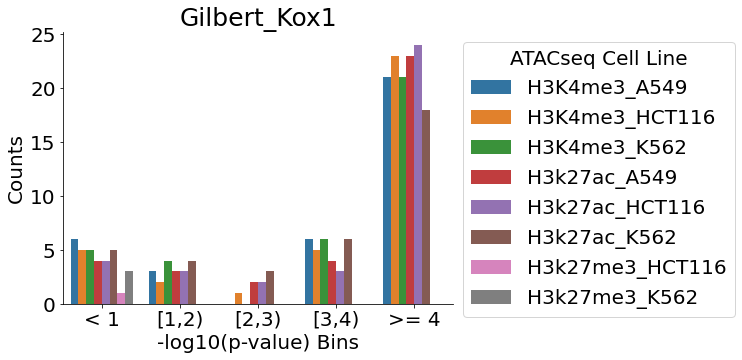

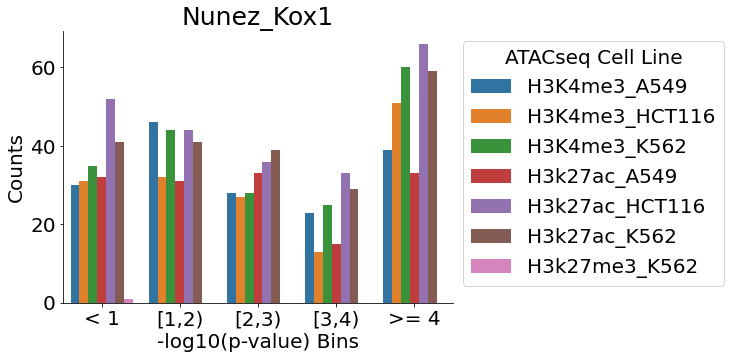

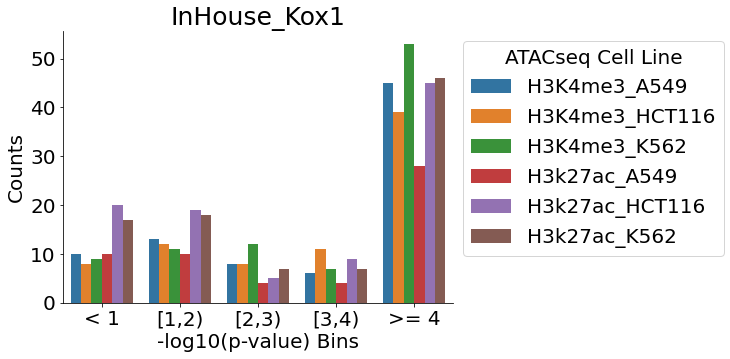

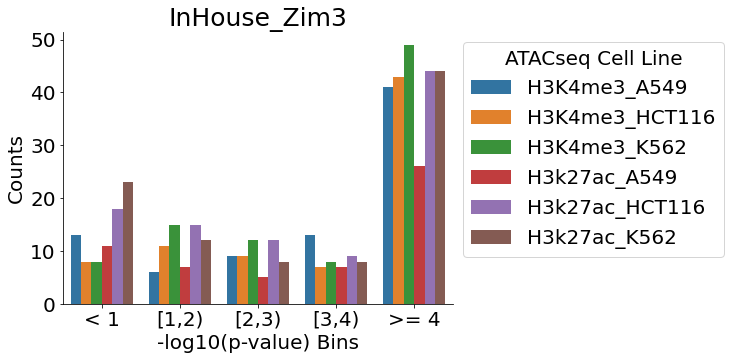

In [18]:
allDataCount = pd.DataFrame()
for dataset in results_df.DataSetID.unique():
    select_pval = results_df[results_df.DataSetID == dataset].copy()
    select_pval['-log10(pval)'] = -np.log10(select_pval['pval'])
    select_pval = categorize_pval(select_pval)
    select_count = pd.DataFrame(select_pval.groupby(['-log10(pval) bins', 'chipseq']).size().reset_index(name='counts'))
    select_count['DataSetID'] = dataset
    allDataCount = pd.concat([allDataCount, select_count])
    chip_graph(select_count, dataset)

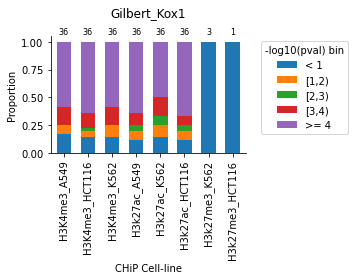

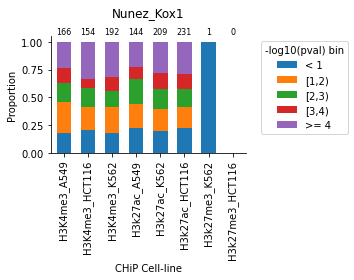

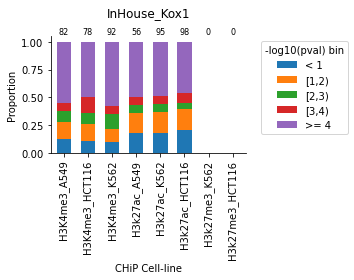

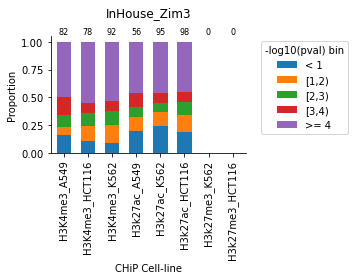

In [19]:
required_columns = ['H3K4me3_A549','H3K4me3_HCT116','H3K4me3_K562','H3k27ac_A549','H3k27ac_K562','H3k27ac_HCT116','H3k27me3_K562', 'H3k27me3_HCT116']

for selectData in allDataCount['DataSetID'].unique():
    select_count = allDataCount[allDataCount.DataSetID == selectData].copy()

    grouped_df = select_count.groupby(['-log10(pval) bins', 'chipseq'])['counts'].sum().unstack().fillna(0)
    
    # Add missing required columns with zeros
    for col in required_columns:
        if (col not in grouped_df.columns):
            grouped_df[col] = 0
    
    # Ensure the columns are in the desired order
    grouped_df = grouped_df[required_columns]

    # Calculate percentages
    grouped_df_percentage = grouped_df.transpose().divide(grouped_df.sum(axis=0), axis=0)
    grouped_df_percentage = grouped_df_percentage[['< 1','[1,2)', '[2,3)','[3,4)','>= 4']]
    
    # Plotting
    fig, ax = plt.subplots(figsize=(5, 4))

    grouped_df_percentage.plot(kind='bar', stacked=True, ax=ax, width=0.6)

    # Add percentages to the bars and the total count
    for i in range(grouped_df_percentage.shape[0]):
        total = 0
        totalCount = grouped_df.iloc[:, i].sum()  # Calculate the total count for each stack
        # Add total count text on top of each stack
        ax.text(i, 1.05, f'{int(totalCount)}', ha='center', va='bottom', fontsize=8, fontweight='light', color='black')

    plt.ylabel('Proportion')
    plt.xlabel('CHiP Cell-line')
    plt.title(selectData, pad=20)
    plt.legend(title='-log10(pval) bin', bbox_to_anchor=(1.05, 1), loc='upper left')
    sns.despine()
    plt.tight_layout()
    plt.show()
